## Importing libraries

In [127]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [152]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.metrics import mean_squared_error
import copy
from mpl_toolkits.mplot3d import Axes3D

### Function for converting rgb images to grayscale

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


### Loading images and building flattened image dataset

Images have been downscaled to 80x80 resolution 

In [4]:
img_dict = {}
img_set = []
files_list=[]
for _, _, files_list in os.walk("./dataset"):
    pass
# print(files_list)
# print("ddsf")
for file in files_list:
#     print("opeing ",file)
    label, rest = file.split('_')
    if img_dict.get(label) == None:
        img_dict[label] = []
    gray = mpimg.imread("./dataset/"+file)
    gray = rgb2gray(gray)
    gray = cv2.resize(gray, (80,80), interpolation = cv2.INTER_AREA)
    img_set.append(gray.flatten())
    img_dict[label].append(gray)

## Calculating covariance marix

In [5]:
img_set = np.array(img_set)
means = np.average(img_set, axis=0).reshape((80,80))

#### Function to calculate covariance matrix

In [6]:
def calc_cov_mat(ip_mat):
    mean_mat = np.sum(ip_mat, axis=0)/ip_mat.shape[0]
    mat_b = ip_mat - mean_mat
    return np.dot(mat_b.transpose(), mat_b)/(ip_mat.shape[0] - 1)

In [7]:
cov_mat = calc_cov_mat(img_set)
cov_mat.shape

(6400, 6400)

#### Applying eigendecomposition to covariance matrix

In [8]:
evals, evecs = np.linalg.eig(cov_mat)

#### Sorting in descending order of eigenvalues

In [9]:
idx = evals.argsort()[::-1]   
eigenValues = evals[idx]
eigenVectors = evecs[:,idx]

#### Eigenvalues and corresponding eigenvectors

In [10]:
print("Eigenvalues\n",eigenValues)
print("Eigenvectors\n",eigenVectors)

Eigenvalues
 [ 3.57371440e+06+0.00000000e+00j  2.77388067e+06+0.00000000e+00j
  1.63084780e+06+0.00000000e+00j ... -6.61025672e-11+0.00000000e+00j
 -8.59827129e-11+1.08320322e-11j -8.59827129e-11-1.08320322e-11j]
Eigenvectors
 [[-0.01058841+0.00000000e+00j  0.00790091+0.00000000e+00j
   0.01385365+0.00000000e+00j ...  0.00103361+0.00000000e+00j
  -0.00024406+2.92871368e-05j -0.00024406-2.92871368e-05j]
 [-0.01068588+0.00000000e+00j  0.00862003+0.00000000e+00j
   0.01257113+0.00000000e+00j ... -0.00348204+0.00000000e+00j
   0.01021624-6.03532544e-04j  0.01021624+6.03532544e-04j]
 [-0.01163404+0.00000000e+00j  0.00851427+0.00000000e+00j
   0.01122017+0.00000000e+00j ...  0.00275467+0.00000000e+00j
   0.00160396-1.32507294e-03j  0.00160396+1.32507294e-03j]
 ...
 [ 0.00163323+0.00000000e+00j -0.01752788+0.00000000e+00j
   0.02947766+0.00000000e+00j ...  0.0180977 +0.00000000e+00j
  -0.03225703+1.03583306e-03j -0.03225703-1.03583306e-03j]
 [ 0.00199612+0.00000000e+00j -0.01664145+0.00000000

## Plot of MSE v/s components retained

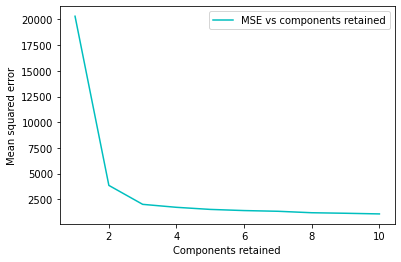

In [11]:
elist = []
max_comps = 10

for ind in range(max_comps):
    trans_mat = np.real(eigenVectors[:,0:ind])
    recon_mat = np.dot(trans_mat, trans_mat.transpose())
    reconstructed_imgs = np.dot(img_set, recon_mat)
    ferror=0
    for col in range(img_set.shape[1]):
        error = mean_squared_error(img_set[:,col], reconstructed_imgs[:,col])
        ferror += error
    ferror /= len(img_set[0])
    elist.append(ferror)
#     print(ferror)


plt.plot([i+1 for i in range(len(elist))], elist, 'c-', label='MSE vs components retained')
plt.legend(loc='best')
# plt.axis([0, 100, 0, 1])
plt.xlabel('Components retained')
plt.ylabel('Mean squared error')
plt.show()


## Plot for variance v/s components retained

In [12]:
target_var = .8

80.0 % variance achieved at  27  components


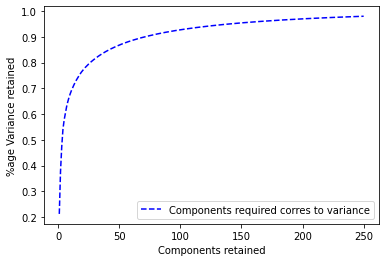

In [13]:
tot_var = np.sum(eigenValues)
perc = []
csum=0
comps = 0
tcomps=0
bl=False
for ind in range(250):
    csum += eigenValues[ind]
    comps += 1
    perc.append(csum/tot_var)
    if bl==False and np.real(csum/tot_var) >= target_var:
        print(target_var*100,"% variance achieved at ",comps," components")
        tcomps=comps
        bl = True


plt.plot([i+1 for i in range(len(perc))], np.real(perc), 'b--',label="Components required corres to variance")
plt.legend(loc='best')
# plt.axis([0, 100, 0, 1])
plt.xlabel('Components retained')
plt.ylabel('%age Variance retained')
# plt.figure(figsize=(20,17))
plt.show()


#### Obtaining the PCA transformation (projection) and reconstruction matrix corresponding to 80% variance retention

In [14]:
trans_mat = np.real(eigenVectors[:,0:tcomps])
recon_mat = np.dot(trans_mat, trans_mat.transpose())

## Images before and after PCA (80% variance retention)

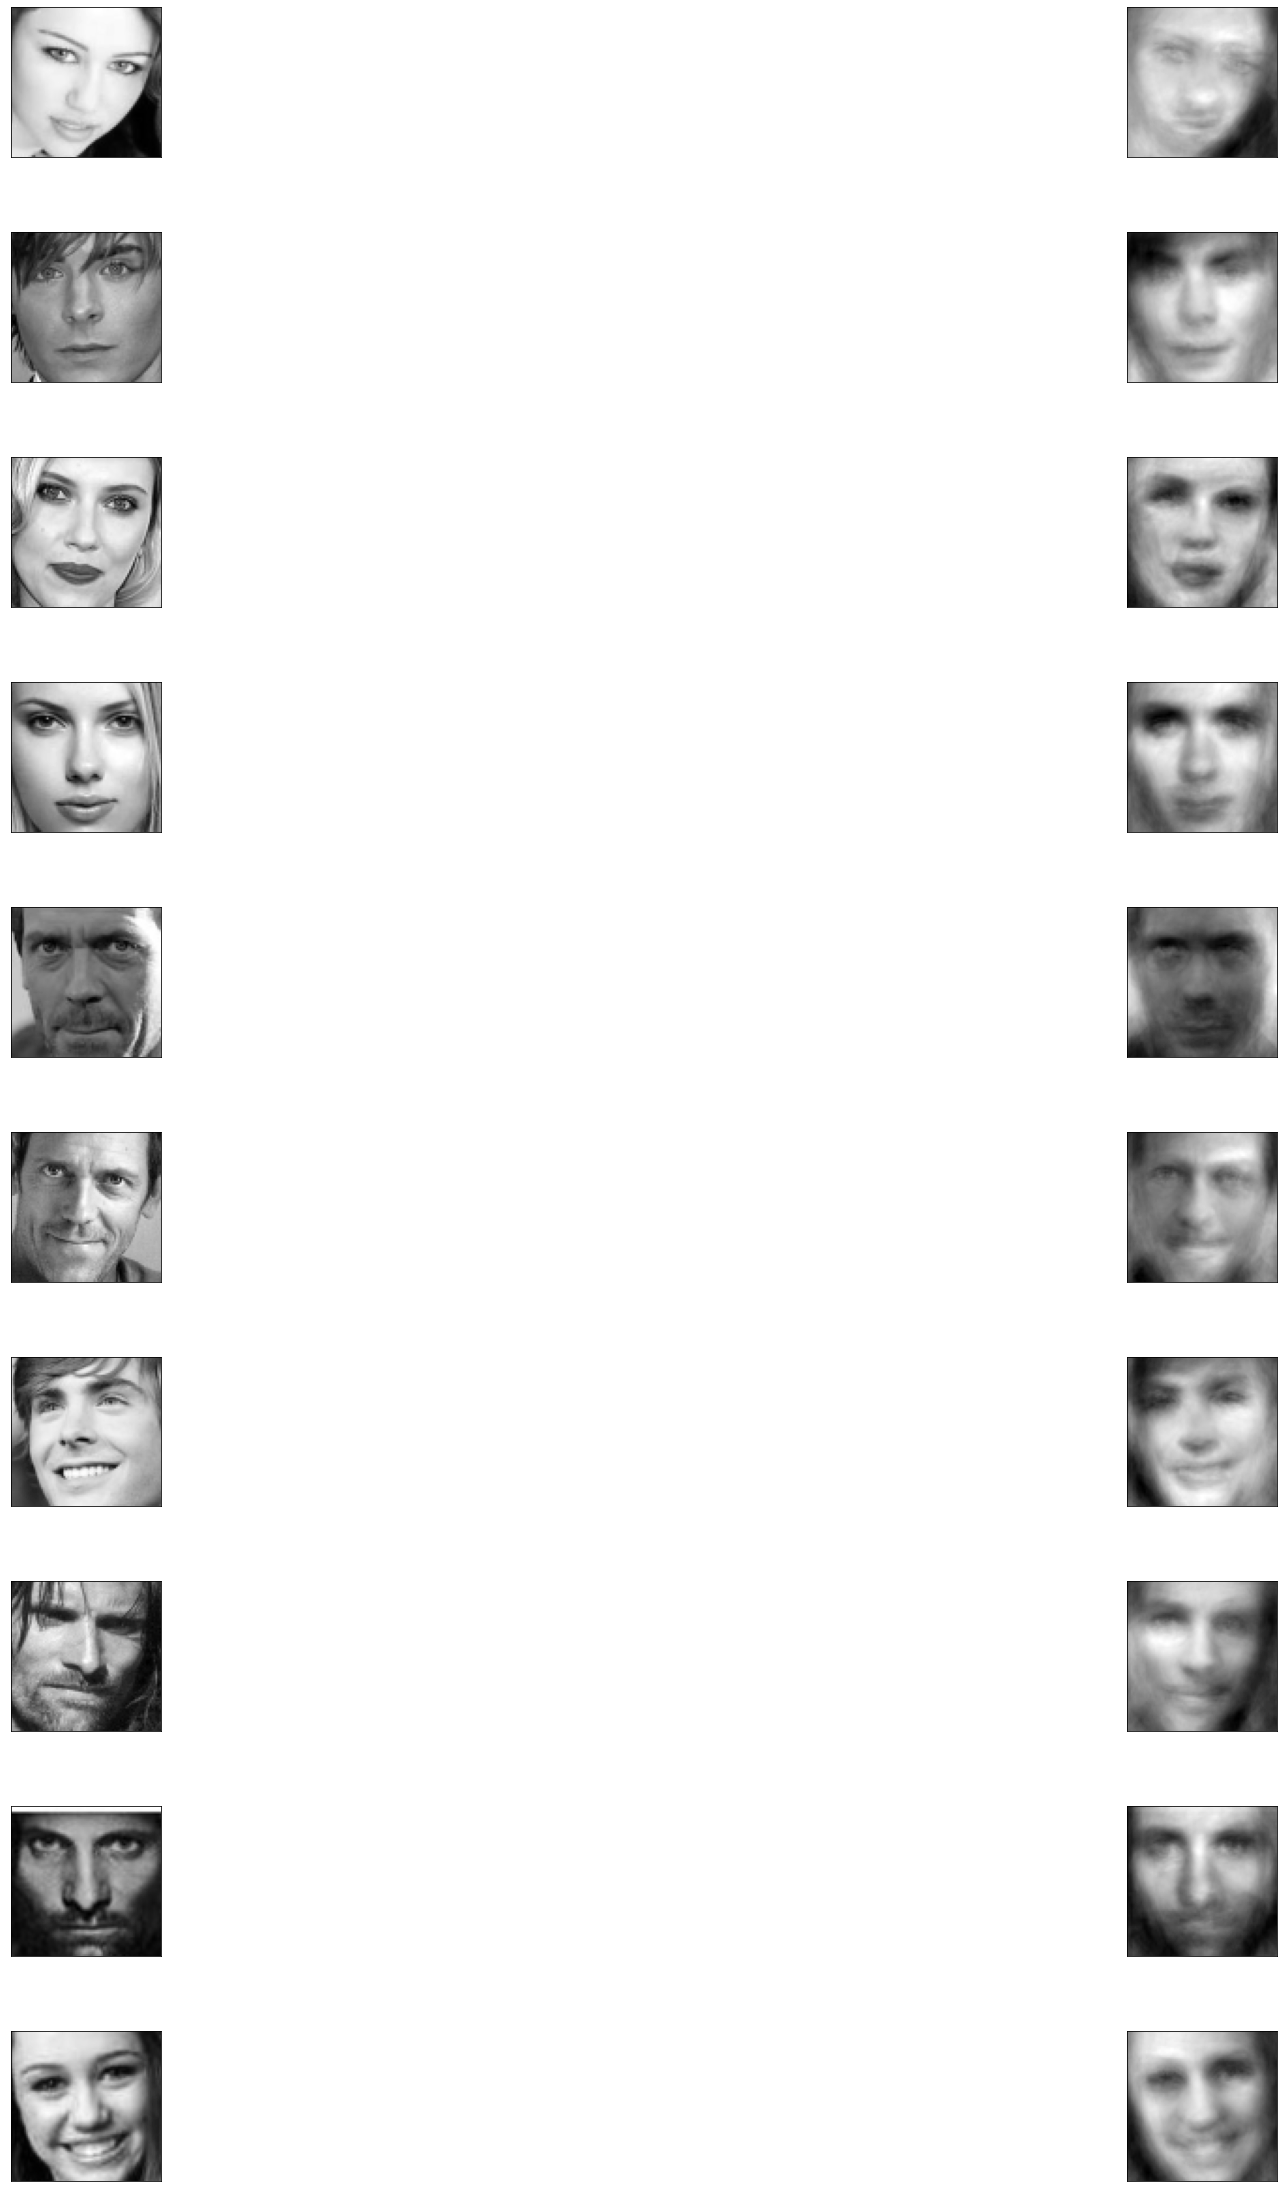

In [15]:
img_to_disp = 10
img_arr = []
for ind in range(img_to_disp):
    rimg =  img_set[np.random.randint(low=0,high=521)]
    img_arr.append(rimg.reshape(80,80))
    nimg = np.dot(rimg-means.flatten(), recon_mat)
    img_arr.append(nimg.reshape(80,80) + means)
    
fig, axes = plt.subplots(img_to_disp, 2,  figsize=(40,40), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.5, wspace=0.001))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_arr[i],cmap='gray')


## Scatter plots

#### In one dimension

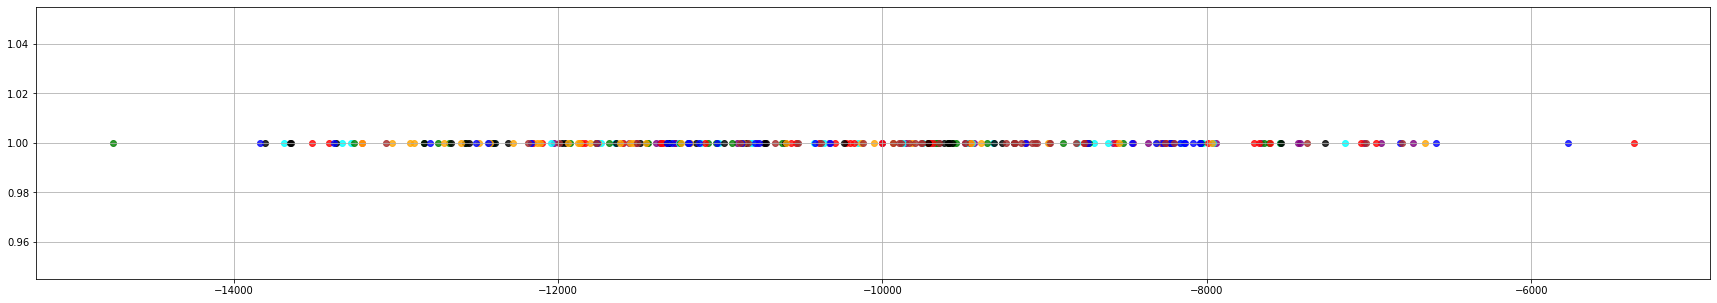

In [146]:
new_dict = copy.deepcopy(img_dict)
images_per_label = 35
trans_mat = np.real(eigenVectors[:,0]).reshape((-1,1))
f_dict = {'000':[], '001':[], '002':[], '003':[], '004':[], '005':[], '006':[], '007':[] }
for label in new_dict.keys():
    for ind in range(images_per_label):
        f_dict[label].append(np.dot(np.array(new_dict[label][ind]).reshape((1,-1)), trans_mat))
plt.figure(figsize=(30,5))
plt.grid()
plt.scatter(f_dict['000'], np.ones_like(f_dict['000']), c='purple', marker='o', linewidth='1', alpha=0.8)
plt.scatter(f_dict['001'], np.ones_like(f_dict['001']), c='cyan', marker='o', linewidth='1', alpha=0.8)
plt.scatter(f_dict['002'], np.ones_like(f_dict['002']), c='green', marker='o', linewidth='1', alpha=0.8)
plt.scatter(f_dict['003'], np.ones_like(f_dict['003']), c='red', marker='o', linewidth='1', alpha=0.8)
plt.scatter(f_dict['004'], np.ones_like(f_dict['004']), c='black', marker='o', linewidth='1', alpha=0.8)
plt.scatter(f_dict['005'], np.ones_like(f_dict['005']), c='orange', marker='o', linewidth='1', alpha=0.8)
plt.scatter(f_dict['006'], np.ones_like(f_dict['006']), c='blue', marker='o', linewidth='1', alpha=0.8)
plt.scatter(f_dict['007'], np.ones_like(f_dict['007']), c='brown', marker='o', linewidth='1', alpha=0.8)
plt.show()
plt.close()

#### In two dimensions

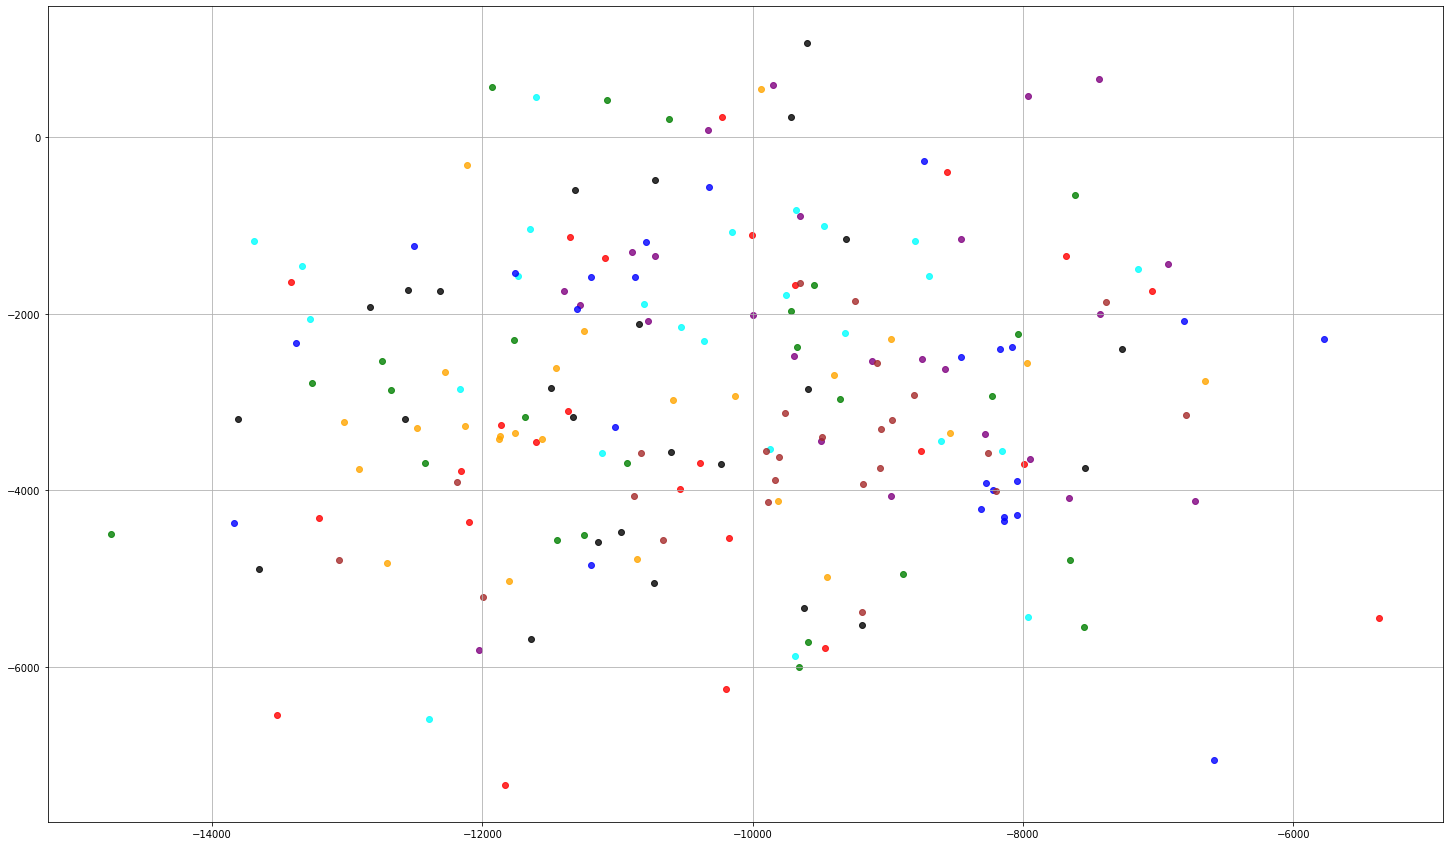

In [148]:
new_dict = copy.deepcopy(img_dict)
images_per_label = 25
trans_mat = np.real(eigenVectors[:,0:2]).reshape((6400,2))
f_dict = {'000':np.array([0,0]), '001':np.array([0,0]), '002':np.array([0,0]), '003':np.array([0,0]), '004':np.array([0,0]), '005':np.array([0,0]), '006':np.array([0,0]), '007':np.array([0,0]) }
for label in new_dict.keys():
    for ind in range(images_per_label):
        f_dict[label] = np.vstack((f_dict[label],(np.dot(np.array(new_dict[label][ind]).reshape((1,-1)), trans_mat))))
for label in new_dict.keys():
    f_dict[label] = f_dict[label][1:,:]
plt.figure(figsize=(25,15))
plt.grid()
plt.scatter(f_dict['000'][:,0], f_dict['000'][:,1], c='purple', marker='o', linewidth='1', alpha=0.8)
plt.scatter(f_dict['001'][:,0], f_dict['001'][:,1], c='cyan', marker='o', linewidth='1', alpha=0.8)
plt.scatter(f_dict['002'][:,0], f_dict['002'][:,1], c='green', marker='o', linewidth='1', alpha=0.8)
plt.scatter(f_dict['003'][:,0], f_dict['003'][:,1], c='red', marker='o', linewidth='1', alpha=0.8)
plt.scatter(f_dict['004'][:,0], f_dict['004'][:,1], c='black', marker='o', linewidth='1', alpha=0.8)
plt.scatter(f_dict['005'][:,0], f_dict['005'][:,1], c='orange', marker='o', linewidth='1', alpha=0.8)
plt.scatter(f_dict['006'][:,0], f_dict['006'][:,1], c='blue', marker='o', linewidth='1', alpha=0.8)
plt.scatter(f_dict['007'][:,0], f_dict['007'][:,1], c='brown', marker='o', linewidth='1', alpha=0.8)
plt.show()
plt.close()

#### In three dimensions

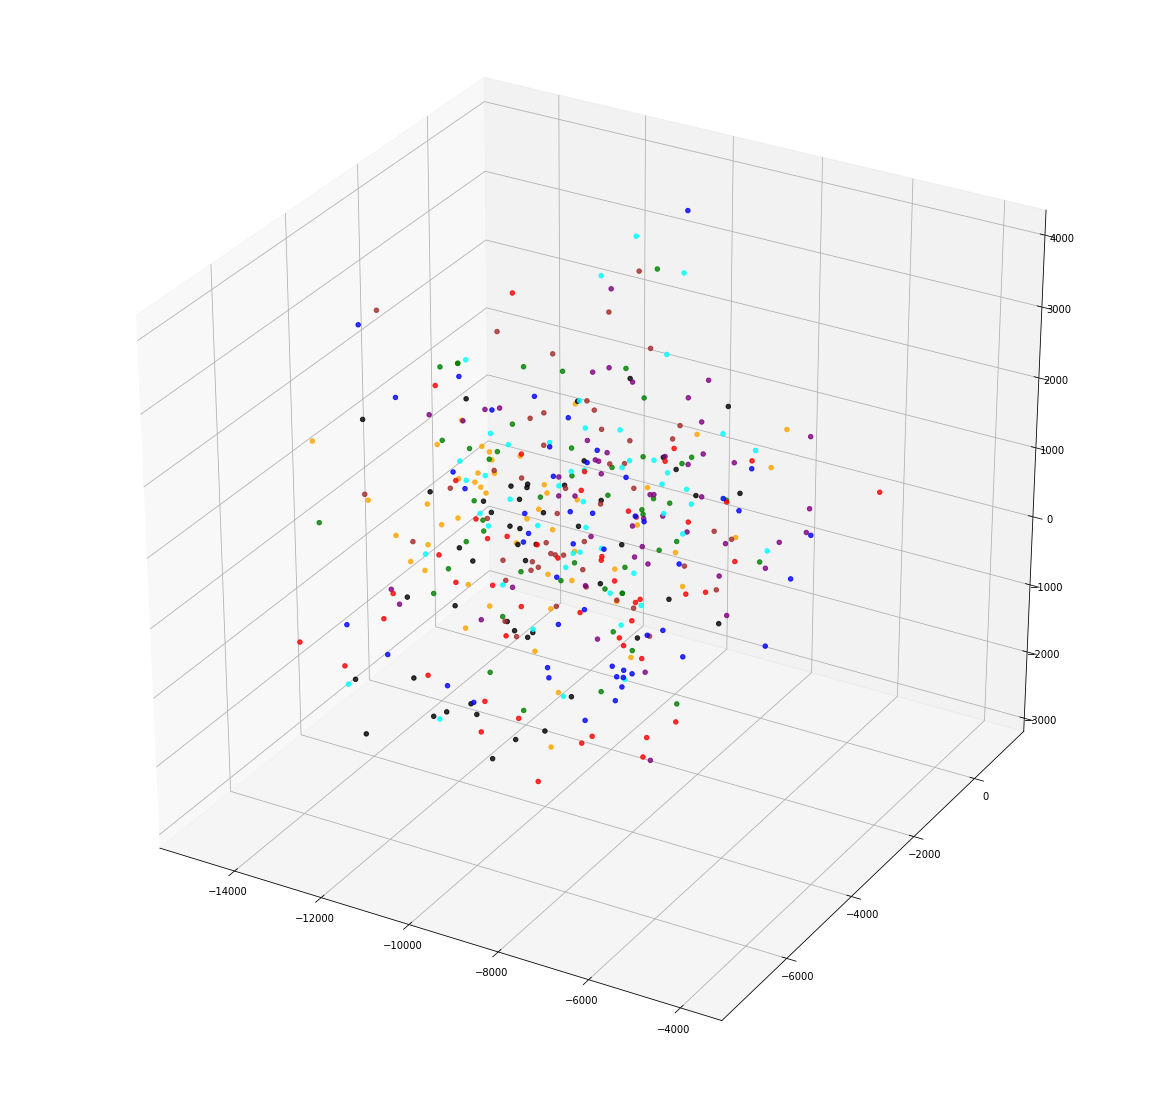

In [195]:
fig = plt.figure()
ax = Axes3D(fig)

new_dict = copy.deepcopy(img_dict)
images_per_label = 50
trans_mat = np.real(eigenVectors[:,0:3]).reshape((6400,3))
f_dict = {'000':np.array([0,0,0], dtype='float64'), 
          '001':np.array([0,0,0], dtype='float64'), 
          '002':np.array([0,0,0], dtype='float64'), 
          '003':np.array([0,0,0], dtype='float64'), 
          '004':np.array([0,0,0], dtype='float64'), 
          '005':np.array([0,0,0], dtype='float64'), 
          '006':np.array([0,0,0], dtype='float64'), 
          '007':np.array([0,0,0], dtype='float64') }
for label in new_dict.keys():
    for ind in range(images_per_label):
        f_dict[label] = np.vstack((f_dict[label],(np.dot(np.array(new_dict[label][ind]).reshape((1,-1)), trans_mat))))
for label in new_dict.keys():
    f_dict[label] = f_dict[label][1:,:]
ax.scatter(f_dict['000'][:,0], f_dict['000'][:,1], f_dict['000'][:,2], c='purple', marker='o', linewidth=1, alpha=0.8)
ax.scatter(f_dict['001'][:,0], f_dict['001'][:,1], f_dict['001'][:,2], c='cyan', marker='o', linewidth=1, alpha=0.8)
ax.scatter(f_dict['002'][:,0], f_dict['002'][:,1], f_dict['002'][:,2], c='green', marker='o', linewidth=1, alpha=0.8)
ax.scatter(f_dict['003'][:,0], f_dict['003'][:,1], f_dict['003'][:,2], c='red', marker='o', linewidth=1, alpha=0.8)
ax.scatter(f_dict['004'][:,0], f_dict['004'][:,1], f_dict['004'][:,2], c='black', marker='o', linewidth=1, alpha=0.8)
ax.scatter(f_dict['005'][:,0], f_dict['005'][:,1], f_dict['005'][:,2], c='orange', marker='o', linewidth=1, alpha=0.8)
ax.scatter(f_dict['006'][:,0], f_dict['006'][:,1], f_dict['006'][:,2], c='blue', marker='o', linewidth=1, alpha=0.8)
ax.scatter(f_dict['007'][:,0], f_dict['007'][:,1], f_dict['007'][:,2], c='brown', marker='o', linewidth=1, alpha=0.8)
plt.rcParams["figure.figsize"] = (12,15)

plt.show()
plt.close()